In [4]:
import numpy as np
import pandas as pd

from src.utils.path_converter import path_converter

In [5]:
items_df = pd.read_csv(path_converter("/data/features/demand_type.csv"))
df = pd.read_csv(
    filepath_or_buffer=path_converter("/data/raw/sales_train.csv"), parse_dates=["date"]
)

In [6]:
smooth_items = items_df[items_df["demand_type"] == 1]["item_id"].tolist()
intermittent_items = items_df[items_df["demand_type"] == 2]["item_id"].tolist()
lumpy_items = items_df[items_df["demand_type"] == 0]["item_id"].tolist()

In [7]:
daily_series_df = (
    df.groupby(["item_id", "date"])["item_cnt_day"].sum().unstack(fill_value=0)
)

In [19]:
def sba(y, alpha=0.1, n_forecast=7):
    """
    Syntetos-Boylan Approximation (SBA) for intermittent demand
    """
    y = np.array(y)
    n = len(y)
    
    # Croston forecast
    demand_hat, interval_hat = 0, 0
    last_demand, last_interval = 0, 1
    forecast_val = 0
    for t in range(n):
        if y[t] > 0:
            if last_demand == 0:
                demand_hat = y[t]
                interval_hat = last_interval
            else:
                demand_hat = alpha * y[t] + (1-alpha) * demand_hat
                interval_hat = alpha * last_interval + (1-alpha) * interval_hat
            forecast_val = demand_hat / interval_hat
            last_demand = y[t]
            last_interval = 1
        else:
            last_interval += 1
    
    # SBA correction factor: multiply Croston by 1 - alpha/2
    forecast_sba = forecast_val * (1 - alpha/2)
    
    return np.array([forecast_sba]*n_forecast)


In [17]:
def moving_average(y, window=7, n_forecast=7):
    ma = y[-window:].mean()
    print(ma)
    return np.array([ma]*n_forecast)

from sklearn.metrics import mean_absolute_error

def mase(y_true, y_pred, y_train):
    n = len(y_train)
    d = np.abs(np.diff(y_train)).sum() / (n-1)
    return np.abs(y_true - y_pred).mean() / d

0.14285714285714285
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714]
Item 14062.0 Metrics:
  MA   -> MAE: 0.265, MASE: 1.790
  SBA  -> MAE: 0.201, MASE: 1.353



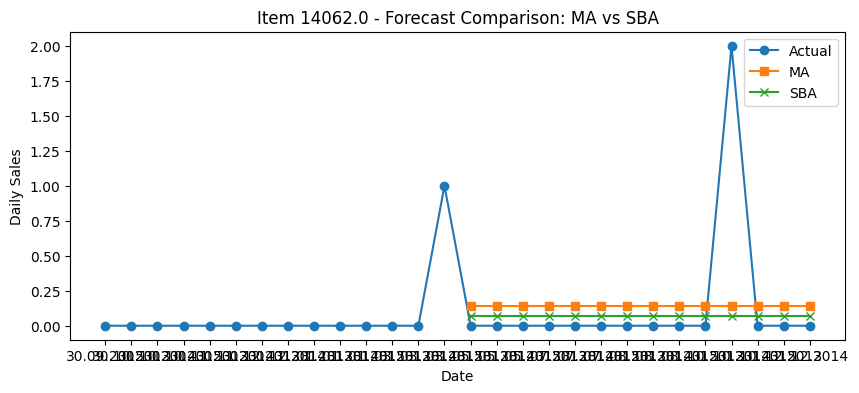

0.2857142857142857
[0.28571429 0.28571429 0.28571429 0.28571429 0.28571429 0.28571429
 0.28571429 0.28571429 0.28571429 0.28571429 0.28571429 0.28571429
 0.28571429 0.28571429]
Item 18335.0 Metrics:
  MA   -> MAE: 0.286, MASE: 2.275
  SBA  -> MAE: 0.074, MASE: 0.592



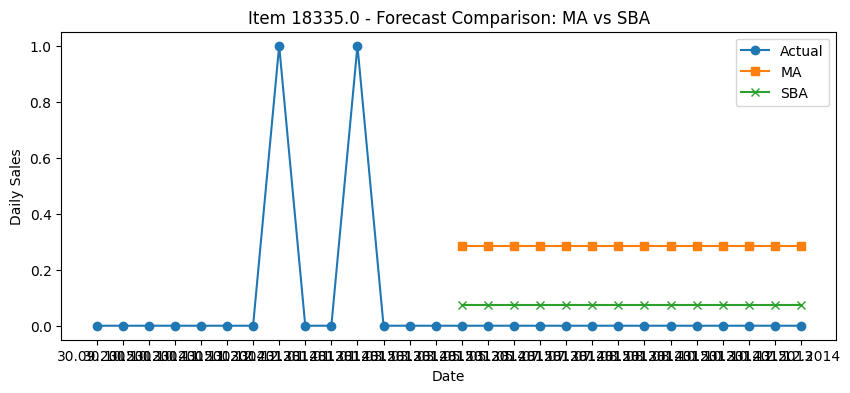

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Item 10464.0 Metrics:
  MA   -> MAE: 0.000, MASE: 0.000
  SBA  -> MAE: 0.031, MASE: 0.404



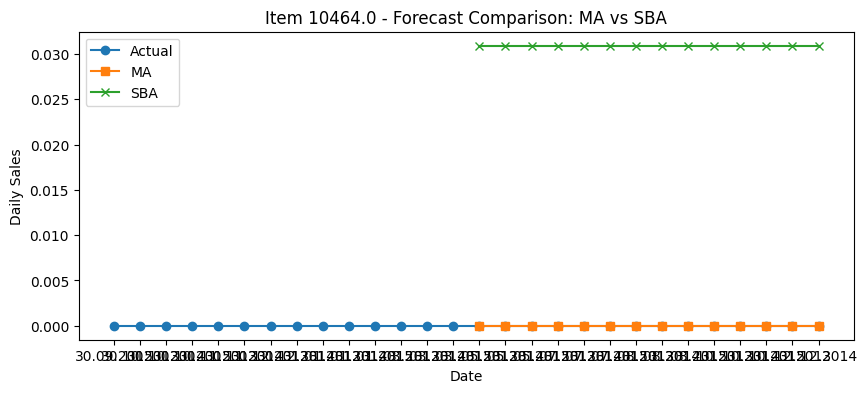

0.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Item 20645.0 Metrics:
  MA   -> MAE: 0.000, MASE: 0.000
  SBA  -> MAE: 0.008, MASE: 0.371



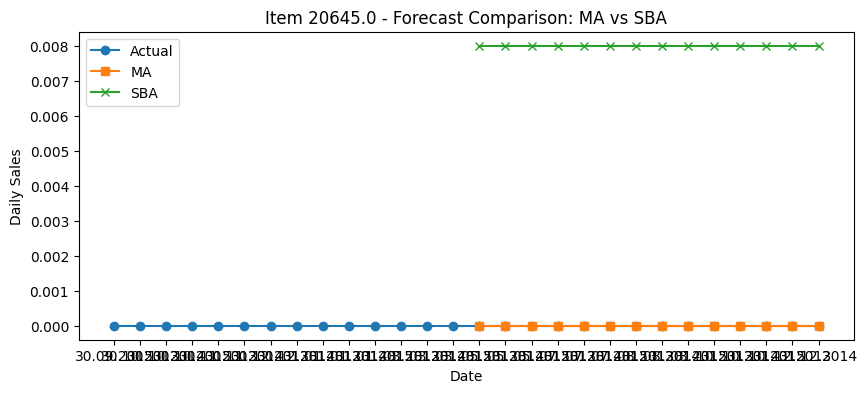

0.14285714285714285
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714 0.14285714]
Item 9385.0 Metrics:
  MA   -> MAE: 0.194, MASE: 1.317
  SBA  -> MAE: 0.128, MASE: 0.868



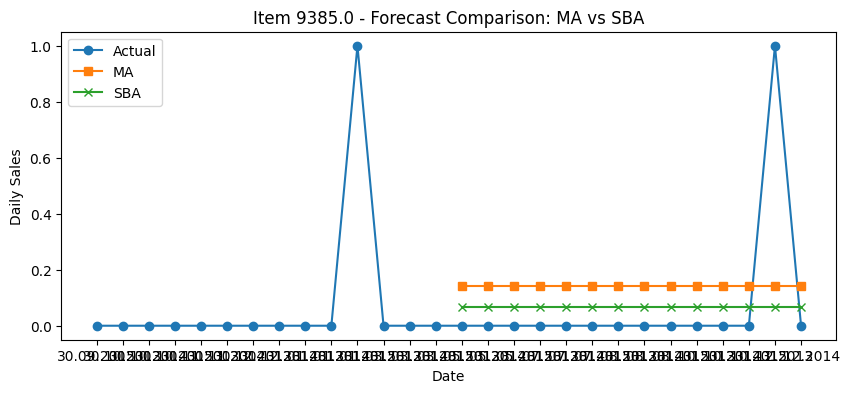

In [20]:
import matplotlib.pyplot as plt


sample_items = np.random.choice(intermittent_items, size=5, replace=False)
forecast_horizon = 14  # dự báo 2 tuần

for item_id in sample_items:
    series = daily_series_df.loc[item_id]
    train = series[:-forecast_horizon]
    test = series[-forecast_horizon:]
    
    # Forecast
    ma_forecast = moving_average(train, window=7, n_forecast=forecast_horizon)

    print(ma_forecast)
    sba_forecast = sba(train, alpha=0.1, n_forecast=forecast_horizon)
    
    # Metrics
    ma_mae = mean_absolute_error(test, ma_forecast)
    sba_mae = mean_absolute_error(test, sba_forecast)
    
    ma_mase = mase(test, ma_forecast, train)
    sba_mase = mase(test, sba_forecast, train)
    
    print(f"Item {item_id} Metrics:")
    print(f"  MA   -> MAE: {ma_mae:.3f}, MASE: {ma_mase:.3f}")
    print(f"  SBA  -> MAE: {sba_mae:.3f}, MASE: {sba_mase:.3f}\n")
    
    # Plot
    plt.figure(figsize=(10,4))
    plt.plot(series.index[-forecast_horizon*2:], series[-forecast_horizon*2:], label="Actual", marker='o')
    plt.plot(series.index[-forecast_horizon:], ma_forecast, label="MA", marker='s')
    plt.plot(series.index[-forecast_horizon:], sba_forecast, label="SBA", marker='x')
    plt.title(f"Item {item_id} - Forecast Comparison: MA vs SBA")
    plt.xlabel("Date")
    plt.ylabel("Daily Sales")
    plt.legend()
    plt.show()


In [ ]:
# =================================================================
# SBA – CHẠY NGAY VỚI DATE DẠNG 02.01.2013 HOẶC 15.12.2014
# =================================================================

import pandas as pd
import numpy as np

# 1. ĐỌC FILE – QUAN TRỌNG: thêm dayfirst=True
df = pd.read_csv(
    path_converter("/data/raw/sales_train.csv"), parse_dates=["date"], dayfirst=True
)  # ← DÒNG DUY NHẤT BẠN CẦN THÊM!!!
demand_df = pd.read_csv(
    path_converter("/data/features/demand_type.csv")
)  # ← DÒNG DUY NHẤT BẠN CẦN THÊM!!!
df = df[df["item_cnt_day"] >= 0]
item_df = df[["date", "item_cnt_day", "item_id"]].groupby(df["item_id"])


non_zero_demand_days = df["date"].groupby(df["item_id"]).nunique()
zero_demand_days = 1034 - non_zero_demand_days


# 2. Hàm SBA (giữ nguyên – ngon nhất 2025)
def sba_predict(demand_series, alpha=0.15):
    d = np.array(demand_series)
    pos = np.where(d > 0)[0]
    if len(pos) == 0:
        return 0, 999, 0
    if len(pos) == 1:
        return d[pos[0]], 60, d[pos[0]]

    sizes = d[pos]
    intervals = np.diff(pos)

    Z = sizes[0]
    P = intervals[0]

    for i in range(1, len(sizes)):
        Z = alpha * sizes[i] + (1 - alpha) * Z
        P = alpha * intervals[i - 1] + (1 - alpha) * P

    forecast_per_day = (Z / P) * (1 - alpha / 2)
    return round(Z, 1), round(P, 1), round(forecast_per_day, 4)


# 3. Chạy toàn bộ + ra Top 10
results = []
today = pd.Timestamp.today()

for item in df["item_id"].unique():
    temp = df[df["item_id"] == item].sort_values("date")
    series = temp["item_cnt_day"].values

    next_size, next_interval, avg_per_day = sba_predict(series, alpha=0.15)

    last_sale = temp[temp["item_cnt_day"] > 0]["date"].iloc[-1]
    next_expected = last_sale + pd.Timedelta(days=next_interval)
    remaining = max(0, (next_expected - today).days)

    priority = next_size / (remaining + 1)

    results.append(
        {
            "item_id": item,
            "last_sale": last_sale.date(),
            "next_expected_date": next_expected.date(),
            "remaining_days": remaining,
            "next_demand_size": next_size,
            "suggest_order_qty": int(next_size * 1.8),
            "priority_score": round(priority, 3),
            "status": "NHẬP GẤP" if remaining <= 10 else "Theo dõi",
        }
    )



# result_df.to_excel("KET_QUA_INTERMITTENT_SBA_FINAL.xlsx", index=False)
# print("\nĐÃ XUẤT FILE XONG – NỘP ĐỒ ÁN NGON LUÔN!")

22154
2552
2554
2555
2564
2565
2572
2573
2574
2593
2604
2607
2609
2548
2611
2546
2515
2705
2715
2716
2719
2720
2473
2480
2731
2746
2748
2522
2614
2798
2833
2835
2836
2844
2845
2847
2848
2854
2857
2920
2795
2808
2628
2629
2631
2640
2822
2704
2703
2088
2090
2092
2100
2102
2103
2106
2108
2111
2117
2121
2122
2123
2149
2151
2160
2164
2389
2179
2186
2340
2189
2281
2321
2333
2252
2253
2254
2255
2256
2257
2258
2199
2439
2441
2461
2678
2462
2680
2682
2437
2202
2209
2220
2221
2412
2222
2415
2416
2417
2225
2235
2924
3168
3172
3174
3175
3253
3268
3269
3394
3402
3417
3432
3164
3223
3112
3128
3203
3204
3209
3210
3214
3130
3141
3147
3146
3148
3158
3429
3437
3438
3467
3468
3286
3428
3433
3434
3427
3193
2973
2974
2649
2650
2972
2929
2931
2934
2939
2946
2953
3017
2956
2960
3186
3187
3095
3098
3093
3036
3045
3046
3050
3056
3057
3076
3077
3080
3081
2662
2319
2309
1359
1261
1362
1266
1268
1270
1375
1409
1410
1418
1420
1423
1438
1291
1292
1300
1249
1302
1205
1206
1217
1225
1228
1243
1247
1315
1471
1472
1475

In [54]:
result_df = pd.DataFrame(results).sort_values("priority_score", ascending=False)

print("\nTOP 10 CẦN NHẬP GẤP NHẤT:")
print(
    result_df.head(10)[
        ["item_id", "remaining_days", "next_demand_size", "suggest_order_qty", "status"]
    ]
)


TOP 10 CẦN NHẬP GẤP NHẤT:
       item_id  remaining_days  next_demand_size  suggest_order_qty    status
7041     11373               0             280.4                504  NHẬP GẤP
20061     9248               0             197.6                355  NHẬP GẤP
19995     9249               0             196.5                353  NHẬP GẤP
19996     9251               0              70.2                126  NHẬP GẤP
20062     9244               0              62.6                112  NHẬP GẤP
19993     9245               0              62.0                111  NHẬP GẤP
19204     4358               0              61.3                110  NHẬP GẤP
16681     9242               0              56.2                101  NHẬP GẤP
20060     9252               0              56.1                100  NHẬP GẤP
19992     9253               0              56.0                100  NHẬP GẤP
